In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example Data

### One sample t-test, Original Code.

These are just copied from `runSMARTClass.py`

In [3]:
from SMARTClass import SMART

# Settings
fName = 'ExampleDataSMART.p'
depVar1 = 'DepVar1'
timeVar1 ='TimeVar1'
depVar2 = 'DepVar2'
timeVar2 = 'TimeVar2'
krnSize = 10
minTime = 100
maxTime = 501
stepTime = 1
nPerm = 1000
baseline = 0.5
sigLevel = 0.05

In [4]:
oneSamp = SMART(fName, depVar1, timeVar1)
oneSamp.runSmooth(krnSize, minTime, maxTime, stepTime)
oneSamp.runPermutations(nPerm, baseline)
oneSamp.runStats(sigLevel)
# oneSamp.runPlot() # doesn't work due to error

In [5]:
# Smoothing
oneSamp.smooth_dv1 # Individually smoothed data
oneSamp.weights_dv1 # Individual weights
oneSamp.weighDv1Average # Average smothed data

# Permutations
oneSamp.permData1 #Permutations for each participant
oneSamp.permWeight1 # Permutation weights for each participant. 

# Stats
oneSamp.sigCL # Significant timepoints in data
print(oneSamp.sumTvals) # The sum of tvalues for the each cluster
oneSamp.permDistr # Clusters in permutations
oneSamp.sigThres # Cluster size threshold

[127.53693834940964, 812.4010006608426, 2098.2741322321417]


355.3820153751521

### Paired-sample t-test, original code

In [6]:
# paired sample
pairedSamp = SMART(fName, depVar1, timeVar1, depVar2, timeVar2)
pairedSamp.runSmooth(krnSize, minTime, maxTime, stepTime)
pairedSamp.runPermutations(nPerm)
pairedSamp.runStats(sigLevel)

In [7]:
# Smoothing
pairedSamp.smooth_dv1 # Individually smoothed data variable 1
pairedSamp.weights_dv1 # Individual weights  variable 1
pairedSamp.weighDv1Average # Average smothed data variable 1
pairedSamp.smooth_dv2 # Individually smoothed data variable 2
pairedSamp.weights_dv2 # Individual weights  variable 2
pairedSamp.weighDv2Average # Average smothed data variable 2

# Permutations
pairedSamp.permData1 #Permutations for each participant variable 1
pairedSamp.permWeight1 # Permutation weights for each participant variable 1
pairedSamp.permData2 #Permutations for each participant variable 2
pairedSamp.permWeight2 # Permutation weights for each participant variable 2

# Stats
pairedSamp.sigCL # Significant timepoints in data
print(pairedSamp.sumTvals) # The sum of tvalues for the each cluster
pairedSamp.permDistr # Clusters in permutations
pairedSamp.sigThres # Cluster size threshold

[1584.2448954963754, 37.360933764395526, 45.57210685674808]


352.6697140625873

### One sample t-test, modified code

In [8]:
from SMART_utils import *

In [9]:
data = pd.read_pickle('ExampleDataSMART.p')

In [10]:
data

,TimeVar1,DepVar1,TimeVar2,DepVar2
0,"[155, 192, 279, 210, 201, 234, 232, 178, 162, ...","[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, ...","[159, 163, 201, 224, 233, 195, 185, 193, 196, ...","[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, ..."
1,"[379, 312, 272, 293, 302, 242, 353, 331, 286, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[386, 437, 422, 243, 305, 428, 311, 306, 308, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, ..."
2,"[192, 208, 236, 237, 186, 235, 210, 196, 193, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[180, 227, 189, 227, 162, 192, 209, 208, 222, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
3,"[397, 291, 412, 329, 428, 497, 478, 444, 422, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[392, 452, 459, 465, 262, 450, 372, 434, 397, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[164, 167, 173, 195, 187, 159, 182, 141, 234, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[160, 175, 162, 182, 179, 152, 186, 154, 172, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,"[390, 434, 328, 216, 203, 317, 245, 406, 402, ...","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[386, 301, 454, 167, 197, 345, 253, 196, 178, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
6,"[158, 196, 261, 207, 273, 220, 223, 340, 252, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[159, 180, 232, 185, 174, 176, 158, 192, 195, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,"[249, 273, 147, 207, 170, 314, 292, 219, 315, ...","[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[261, 185, 172, 156, 286, 301, 196, 278, 210, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ..."
8,"[391, 400, 237, 295, 433, 372, 315, 303, 380, ...","[1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, ...","[228, 241, 349, 234, 292, 306, 294, 320, 431, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"[344, 331, 214, 378, 221, 275, 281, 172, 365, ...","[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[214, 418, 296, 388, 158, 334, 363, 326, 169, ...","[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, ..."


In [11]:
params = {
'krnSize' : 10,
'minTime' : 100,
'maxTime' : 501,
'stepSize' : 1,
'nPerm' : 1000,
'baseline' : 0.5,
'sigLevel' : 0.05,
'nJobs' : -1, # use all available workers
}

In [12]:
# run one sample SMART
oneSamp = {}
oneSamp['res'] = run_smart_oneSamp(data, 'DepVar1', 'TimeVar1', params, runPerm=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    9.9s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:   10.5s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   10.8s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   12.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   12.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   13.5s finished


time taken: 14.424482822418213 seconds


In [13]:
get_SMART_results(oneSamp) # only significant clusters arw shown

,key,index,baseline,sigLevel,sumTvals,sigThres,permDistLen,start,end,start_value,end_value
0,res,1,0.5,0.05,812.401001,326.296628,1000,149.0,261.0,0.363114,0.401047
1,res,2,0.5,0.05,2098.274132,326.296628,1000,288.0,500.0,0.657557,0.765226


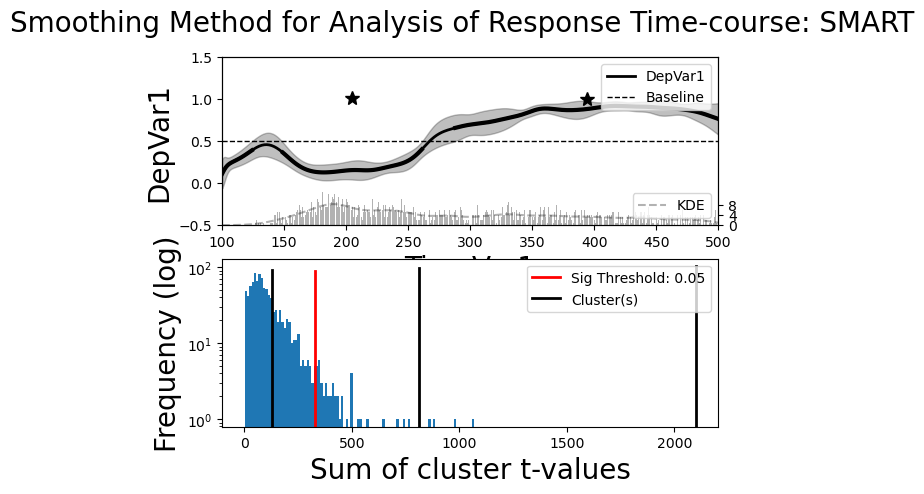

In [20]:
oneSamp['res'].runPlot()

### Paired sample t-test, modified code

In [14]:
# run paired sample SMART
pairedSamp = {}
pairedSamp['res'] = run_smart_pairedSamp(data, 'DepVar1', 'TimeVar1', 'DepVar2','TimeVar2', params, runPerm=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    3.2s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    4.0s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    5.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    5.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    6.5s finished


time taken: 7.428283929824829 seconds


In [15]:
get_SMART_results(pairedSamp, paired=True) # only significant clusters arw shown

,key,index,baseline,sigLevel,sumTvals,sigThres,permDistLen,start,end,start_value_0,end_value_0,start_value_1,end_value_1
0,res,0,0,0.05,1584.244895,362.275028,1000,100.0,306.0,0.110574,0.707393,0.974924,0.861947


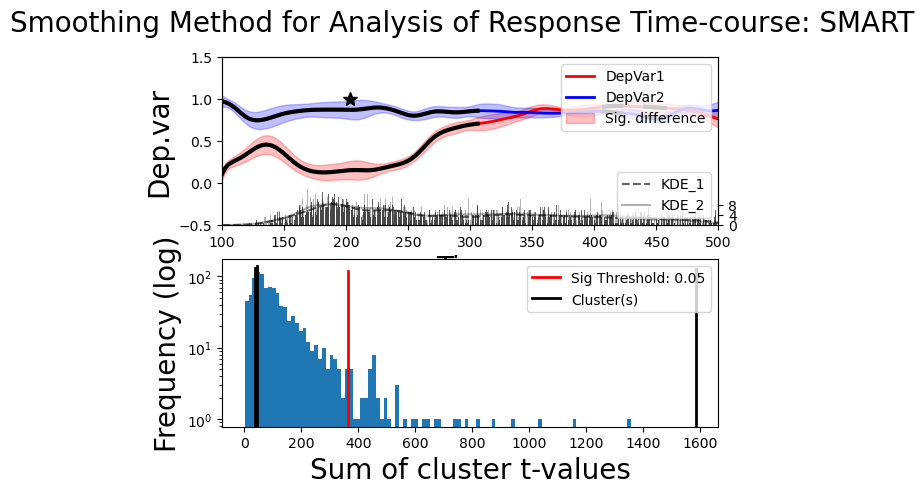

In [22]:
pairedSamp['res'].runPlot()